In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

In [2]:
# Dataset Paths
base_dir = "processed_dataset"
train_dir = os.path.join(base_dir, "training")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "testing")

In [3]:
# Image Specifications
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  # Added for robustness
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
# Male Data Generator
male_train_generator = train_datagen.flow_from_directory(
    os.path.join(train_dir, "male"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
male_test_generator = test_datagen.flow_from_directory(
    os.path.join(test_dir, "male"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
male_val_generator = val_datagen.flow_from_directory(
    os.path.join(val_dir, "male"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4753 images belonging to 7 classes.
Found 1022 images belonging to 7 classes.
Found 1015 images belonging to 7 classes.


In [6]:
# Female Data Generator
female_train_generator = train_datagen.flow_from_directory(
    os.path.join(train_dir, "female"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
female_test_generator = test_datagen.flow_from_directory(
    os.path.join(test_dir, "female"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
female_val_generator = val_datagen.flow_from_directory(
    os.path.join(val_dir, "female"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2952 images belonging to 6 classes.
Found 637 images belonging to 6 classes.
Found 634 images belonging to 6 classes.


In [7]:
# Check Number of Classes
print("Male Classes:", male_train_generator.class_indices)
print("Female Classes:", female_train_generator.class_indices)

num_male_classes = len(male_train_generator.class_indices)  # Should be 6
num_female_classes = len(female_train_generator.class_indices)  # Should be 5

Male Classes: {'non-scalp': 0, 'stage 1': 1, 'stage 2': 2, 'stage 3': 3, 'stage 4': 4, 'stage 5': 5, 'stage 6': 6}
Female Classes: {'non-scalp': 0, 'stage 1': 1, 'stage 2': 2, 'stage 3': 3, 'stage 4': 4, 'stage 5': 5}


In [8]:
def create_cnn(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)  # Adjusted dropout rate
    return Model(inputs, x)

In [9]:
def create_ann(input_dim, output_dim):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),  # Adjusted dropout
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),  # Reduced dropout in final layer

        Dense(output_dim, activation='softmax')
    ])
    return model

In [10]:
# Confusion Matrix Plotting Function
def plot_confusion_matrix(model, test_generator, class_labels, title):
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
# Build CNN-ANN Hybrid Model
cnn_base = create_cnn()
feature_dim = cnn_base.output_shape[-1]


In [12]:
# Male Classifier
male_ann = create_ann(feature_dim, num_male_classes)
male_output = male_ann(cnn_base.output)

# Female Classifier
female_ann = create_ann(feature_dim, num_female_classes)
female_output = female_ann(cnn_base.output)


c:\Users\Anvitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Combined Model
model_male = Model(inputs=cnn_base.input, outputs=male_output)
model_female = Model(inputs=cnn_base.input, outputs=female_output)

# Compile Models with Separate Optimizers
male_optimizer = Adam(learning_rate=1e-3)
female_optimizer = Adam(learning_rate=1e-3)

model_male.compile(loss="categorical_crossentropy", optimizer=male_optimizer, metrics=["accuracy"])
model_female.compile(loss="categorical_crossentropy", optimizer=female_optimizer, metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [14]:
# Train Male Model
print("\nTraining Male Model...\n")
history_male = model_male.fit(
    male_train_generator,
    validation_data=male_val_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)



Training Male Model...



c:\Users\Anvitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.3025 - loss: 2.0200 - val_accuracy: 0.1429 - val_loss: 3.7557 - learning_rate: 0.0010
Epoch 2/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.3947 - loss: 1.5431 - val_accuracy: 0.1429 - val_loss: 3.5283 - learning_rate: 0.0010
Epoch 3/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.4273 - loss: 1.4325 - val_accuracy: 0.2256 - val_loss: 2.0996 - learning_rate: 0.0010
Epoch 4/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.4566 - loss: 1.3348 - val_accuracy: 0.4670 - val_loss: 1.2864 - learning_rate: 0.0010
Epoch 5/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.4808 - loss: 1.2781 - val_accuracy: 0.4621 - val_loss: 1.2743 - learning_rate: 0.0010
Epoch 6/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.4991 - loss: 1.2559 - val_accuracy: 0.3596 - val_loss: 1.7854 - learning_rate: 0.0010
Epoch 7/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.5332 - loss: 1.

In [15]:
# Save Male Model After Training
model_male.save("model/hairfall_stage_male.h5")

In [16]:
def print_classification_report(model, test_generator, class_labels, title):
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes
    print(f"\nClassification Report - {title}")
    print(classification_report(y_true, y_pred, target_names=class_labels))


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 605ms/step


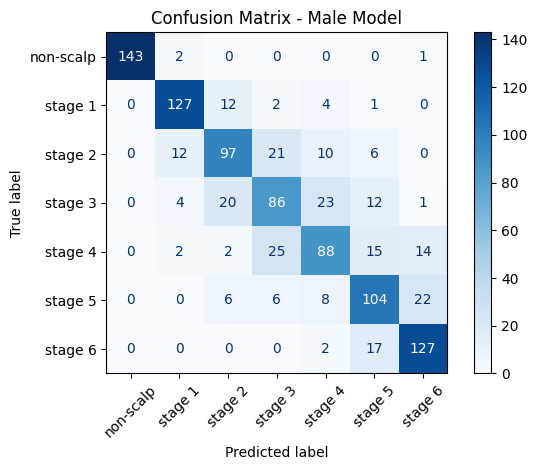

In [17]:
# Confusion Matrix - Male
plot_confusion_matrix(
    model=model_male,
    test_generator=male_test_generator,
    class_labels=list(male_train_generator.class_indices.keys()),
    title="Confusion Matrix - Male Model"
)

In [18]:
print_classification_report(
    model=model_male,
    test_generator=male_test_generator,
    class_labels=list(male_train_generator.class_indices.keys()),
    title="Male Model"
)


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step

Classification Report - Male Model
              precision    recall  f1-score   support

   non-scalp       1.00      0.98      0.99       146
     stage 1       0.86      0.87      0.87       146
     stage 2       0.71      0.66      0.69       146
     stage 3       0.61      0.59      0.60       146
     stage 4       0.65      0.60      0.63       146
     stage 5       0.67      0.71      0.69       146
     stage 6       0.77      0.87      0.82       146

    accuracy                           0.76      1022
   macro avg       0.75      0.76      0.75      1022
weighted avg       0.75      0.76      0.75      1022



In [19]:
# Evaluate Male Model on Test Set
test_loss_male, test_acc_male = model_male.evaluate(male_test_generator)
print(f"Male Model - Final Training Accuracy: {history_male.history['accuracy'][-1]:.2f}")
print(f"Male Model - Final Validation Accuracy: {history_male.history['val_accuracy'][-1]:.2f}")
print(f"Male Model - Test Accuracy: {test_acc_male:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.8299 - loss: 0.4577
Male Model - Final Training Accuracy: 0.73
Male Model - Final Validation Accuracy: 0.77
Male Model - Test Accuracy: 0.76


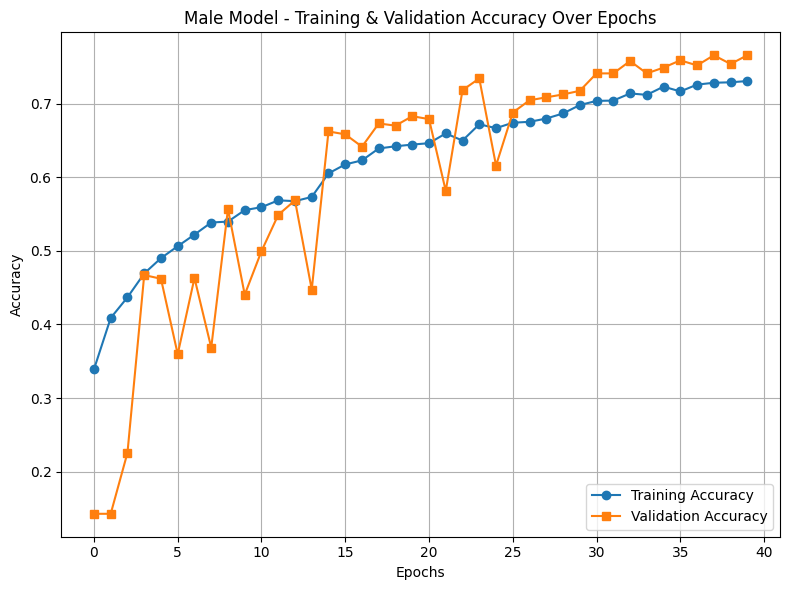

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history_male.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_male.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Male Model - Training & Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Train Female Model
print("\nTraining Female Model...\n")
history_female = model_female.fit(
    female_train_generator,
    validation_data=female_val_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)



Training Female Model...



c:\Users\Anvitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3947 - loss: 1.7264 - val_accuracy: 0.4953 - val_loss: 1.6322 - learning_rate: 0.0010
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.5158 - loss: 1.2244 - val_accuracy: 0.5599 - val_loss: 1.1134 - learning_rate: 0.0010
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5514 - loss: 1.0796 - val_accuracy: 0.5694 - val_loss: 1.1808 - learning_rate: 0.0010
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5547 - loss: 1.0758 - val_accuracy: 0.6341 - val_loss: 0.8762 - learning_rate: 0.0010
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5920 - loss: 0.9795 - val_accuracy: 0.5379 - val_loss: 1.1960 - learning_rate: 0.0010
Epoch 6/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6002 - loss: 0.9541 - val_accuracy: 0.5994 - val_loss: 0.9224 - learning_rate: 0.0010
Epoch 7/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5968 - loss: 0.9378 - val_acc

In [23]:
# Save Male Model After Training
model_male.save("model/hairfall_stage_female.h5")

In [24]:
# Evaluate Female Model on Test Set
test_loss_female, test_acc_female = model_female.evaluate(female_test_generator)
print(f"Female Model - Final Training Accuracy: {history_female.history['accuracy'][-1]:.2f}")
print(f"Female Model - Final Validation Accuracy: {history_female.history['val_accuracy'][-1]:.2f}")
print(f"Female Model - Test Accuracy: {test_acc_female:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.8343 - loss: 0.3878
Female Model - Final Training Accuracy: 0.72
Female Model - Final Validation Accuracy: 0.71
Female Model - Test Accuracy: 0.74


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step


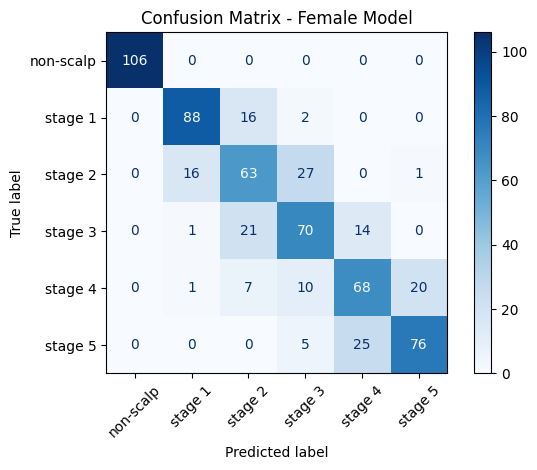

In [25]:
# Confusion Matrix - Female
plot_confusion_matrix(
    model=model_female,
    test_generator=female_test_generator,
    class_labels=list(female_train_generator.class_indices.keys()),
    title="Confusion Matrix - Female Model"
)

In [26]:
print_classification_report(
    model=model_female,
    test_generator=female_test_generator,
    class_labels=list(female_train_generator.class_indices.keys()),
    title="Female Model"
)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step

Classification Report - Female Model
              precision    recall  f1-score   support

   non-scalp       1.00      1.00      1.00       106
     stage 1       0.83      0.83      0.83       106
     stage 2       0.59      0.59      0.59       107
     stage 3       0.61      0.66      0.64       106
     stage 4       0.64      0.64      0.64       106
     stage 5       0.78      0.72      0.75       106

    accuracy                           0.74       637
   macro avg       0.74      0.74      0.74       637
weighted avg       0.74      0.74      0.74       637



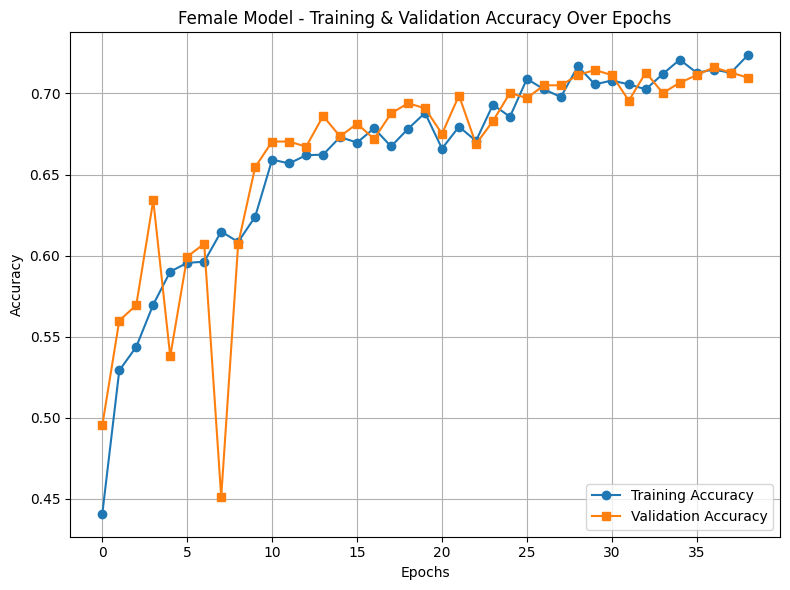

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history_female.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_female.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Female Model - Training & Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
import tensorflow as tf
image = tf.keras.preprocessing.image
import numpy as np

# Load Models Once
model_male = tf.keras.models.load_model('model/hairfall_stage_male.h5')
model_female = tf.keras.models.load_model('model/hairfall_stage_female.h5')

# Image Size
IMG_SIZE = (224, 224)

# Class Labels
male_class_labels = ["non-scalp", "Stage 1", "Stage 2", "Stage 3", "Stage 4", "Stage 5", "Stage 6"]
female_class_labels = ["non-scalp", "Stage 1", "Stage 2", "Stage 3", "Stage 4", "Stage 5"]

# Index of non-scalp class (always 0)
non_scalp_index = 0

def preprocess_image(image_path):
    """Preprocess the image for prediction."""
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_stage(image_path, gender):
    """Predict hair fall stage or detect invalid image."""
    img_array = preprocess_image(image_path)

    if gender.lower() == 'male':
        model = model_male
        class_labels = male_class_labels
    elif gender.lower() == 'female':
        model = model_female
        class_labels = female_class_labels
    else:
        raise ValueError("Invalid gender! Must be 'male' or 'female'.")

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    print(f"[DEBUG] Predicted Class Index: {predicted_class}, Confidence: {confidence:.2f}")

    # Handle non-scalp image
    if predicted_class == non_scalp_index:
        return "Invalid image! Please upload a scalp image.", None

    return class_labels[predicted_class], confidence

# ---------- Example Usage ----------

# Upload a valid female scalp image
image_path_valid_female = r"D:\Final project\top_2_f.jpg"

# Upload an invalid image (non-scalp)
image_path_invalid = r"C:\Users\Anvitha\Pictures\frog.jpg"

# Test valid female image
result_female, conf_female = predict_stage(image_path_valid_female, gender="female")
print(f"\nResult: {result_female}, Confidence: {conf_female:.2f}" if conf_female else f"\n{result_female}")

# Test invalid image with female selected
result_invalid, conf_invalid = predict_stage(image_path_invalid, gender="female")
print(f"\nResult: {result_invalid}" if conf_invalid is None else f"\nResult: {result_invalid}, Confidence: {conf_invalid:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
[DEBUG] Predicted Class Index: 2, Confidence: 0.50

Result: Stage 2, Confidence: 0.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[DEBUG] Predicted Class Index: 0, Confidence: 0.58

Result: Invalid image! Please upload a scalp image.
